# Obesity Level Classification Using Physical Condition and Lifestyle Habit Predictors

# Introduction

Obesity is defined as a disease involving excessive body fat and can significantly impact the health of an individual. In comparison to people with normal weight, those with obesity are associated with a higher risk of negative health conditions such as Type 2 diabetes, heart disease and cancer (Nguyen, 2010). Dietary changes, lifestyle habits, and treatment can positively influence the obesity level of an individual (Trivedi, 2014). In our data analysis, we would like to classify the obesity level category for an individual using physical condition and lifestyle habits, in order for them to gain knowledge of their current health and to help inform future lifestyle choices.

Question: What is the obesity level category (underweight, normal, Overweight I, Overweight II, Obesity I, Obesity II, Obesity III) of a new observation predicted by physical condition and eating habits?

The dataset used includes data on the estimated obesity levels of individuals from Mexico, Peru and Columbia using eating habits and physical conditions. The dataset classifies an individual into one of the seven obesity level classes (outlined above) and contains 17 attributes with 2111 records. Some of the data was directly collected from web users, while others were synthetically generated.

## Data download and wrangling

### Libraries

Loaded the packages necessary for our analysis

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Data download

Download the obesity data set from the website and store the data frame in obesity_data.

In [2]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic%20(2).zip",temp)
obesity_data <- read.csv(unz(temp, "ObesityDataSet_raw_and_data_sinthetic.csv"))
unlink(temp)

### Wrangling data

Clean up the obesity_data by selecting the only columns needed for analysis (predictors and target variable) and change NObeyesdad into factor since it is going to be the target variable.

In [3]:
obesity <- obesity_data %>%
            mutate(NObeyesdad = as_factor(NObeyesdad), CH2O = CH2O - 1) %>%
            select(Weight, FAF, CH2O, TUE, NObeyesdad)
head(obesity)

,Weight,FAF,CH2O,TUE,NObeyesdad
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,64.0,0,1,1,Normal_Weight
2,56.0,3,2,0,Normal_Weight
3,77.0,2,1,1,Normal_Weight
4,87.0,2,1,0,Overweight_Level_I
5,89.8,0,1,0,Overweight_Level_II
6,53.0,0,1,0,Normal_Weight


<br>

## Building our model

### Splitting data into training and testing data

We split our data into training and testing data in order to build our K-nearest neighbor classifier in order to be able to further evaluate the accuracy of our classifier.

The training set will be used to build the classifier and the test set will then be used to test the accuracy of our classifier.

In [4]:
set.seed(255)

obesity_split <- initial_split(obesity, prop = 0.75, strata = NObeyesdad)
obesity_train <- training(obesity_split)
obesity_test <- testing(obesity_split)

<br>

The reason we summarize and visualize the training data only is because we build our model using the training data, not including testing data.

### Summarizing the training data set

In [5]:
obesity_num <- obesity_train %>%
    select(Weight, FAF, CH2O, TUE) %>%
    pivot_longer(cols = Weight:TUE,
                names_to = "Variable",
                values_to = "Stat") %>%
    group_by(Variable) %>%
    summarize(Minimum = min(Stat), Maximum = max(Stat), Mean = mean(Stat), Median = median(Stat), Mode = names(table(Stat))[table(Stat)==max(table(Stat))], 
                  Standard_deviation = sd(Stat))

obesity_num

`summarise()` ungrouping output (override with `.groups` argument)



Variable,Minimum,Maximum,Mean,Median,Mode,Standard_deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
CH2O,0,2,1.0159633,1.000000,1,0.6089689
FAF,0,3,1.0180357,1.000000,0,0.8593662
TUE,0,2,0.6541388,0.604079,0,0.6126947
Weight,39,173,86.6391044,82.665425,80,26.2357030


### Visualizing the training data set

In [6]:
weight_dist <- ggplot(obesity_train, aes(x = Weight, colour = NObeyesdad)) +
                geom_density() +
                labs(x = "Weight (kg)", y = "Density", color = "Obesity Level", title = "Density plot of weight by obesity level") +
                theme(text = element_text(size = 20))

weight_faf_plot <- ggplot(obesity_train, aes(x = Weight, y = FAF, color = NObeyesdad)) +
                    geom_point() +
                    labs(x = "Weight (kg)", y = "Physical Activity Frequency", color = "Obesity Level") +
                    theme(text = element_text(size = 20))

options(repr.plot.length = 10, repr.plot.width = 15)

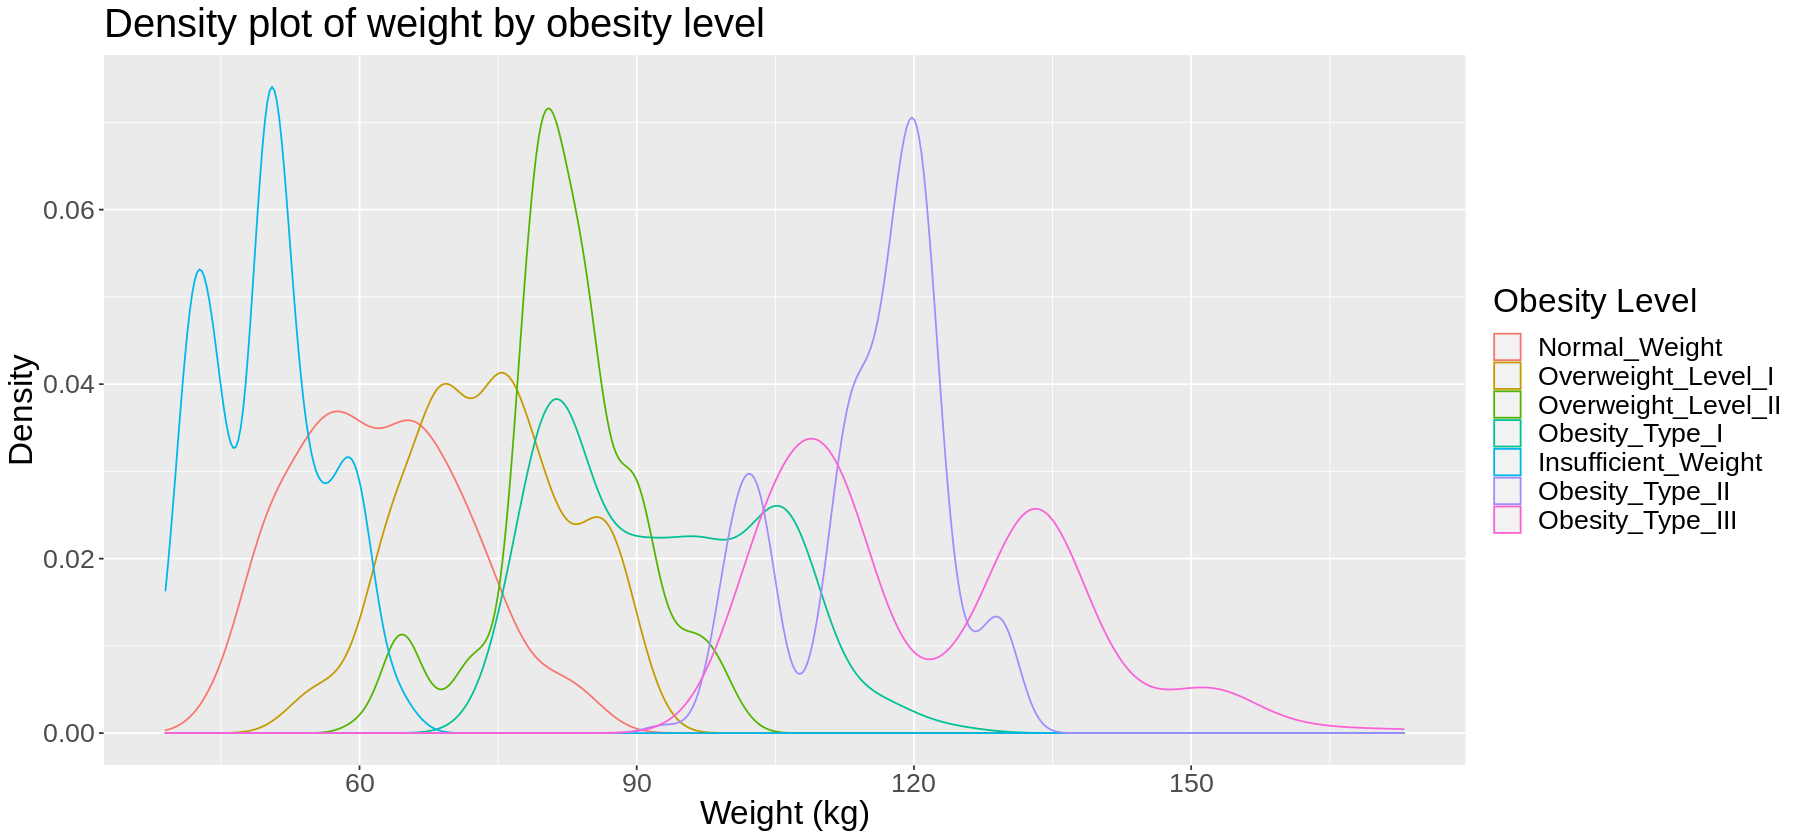

In [7]:
weight_dist

The plot above shows the density of different weights with the various colours indicating different obesity level categories ranging from Insufficient Weight to Obesity Level III. Density is on the y-axis and weight (in kg) is shown on the x-axis. From the plot above, we can see that lower obesity level class have higher density on smaller weight (left-side of the x-axis), while higher obesity level class have higher density on larger weight (right-side of the x-axis). For example, Obesity Type II (the purple line) has the highest density of about 0.07 around 120 kg while normal weight has a peak of density (~0.04) at 60 kg. This indicates that Weight has a strong correlation with Obesity Level where higher obesity level class associated with larger weight.

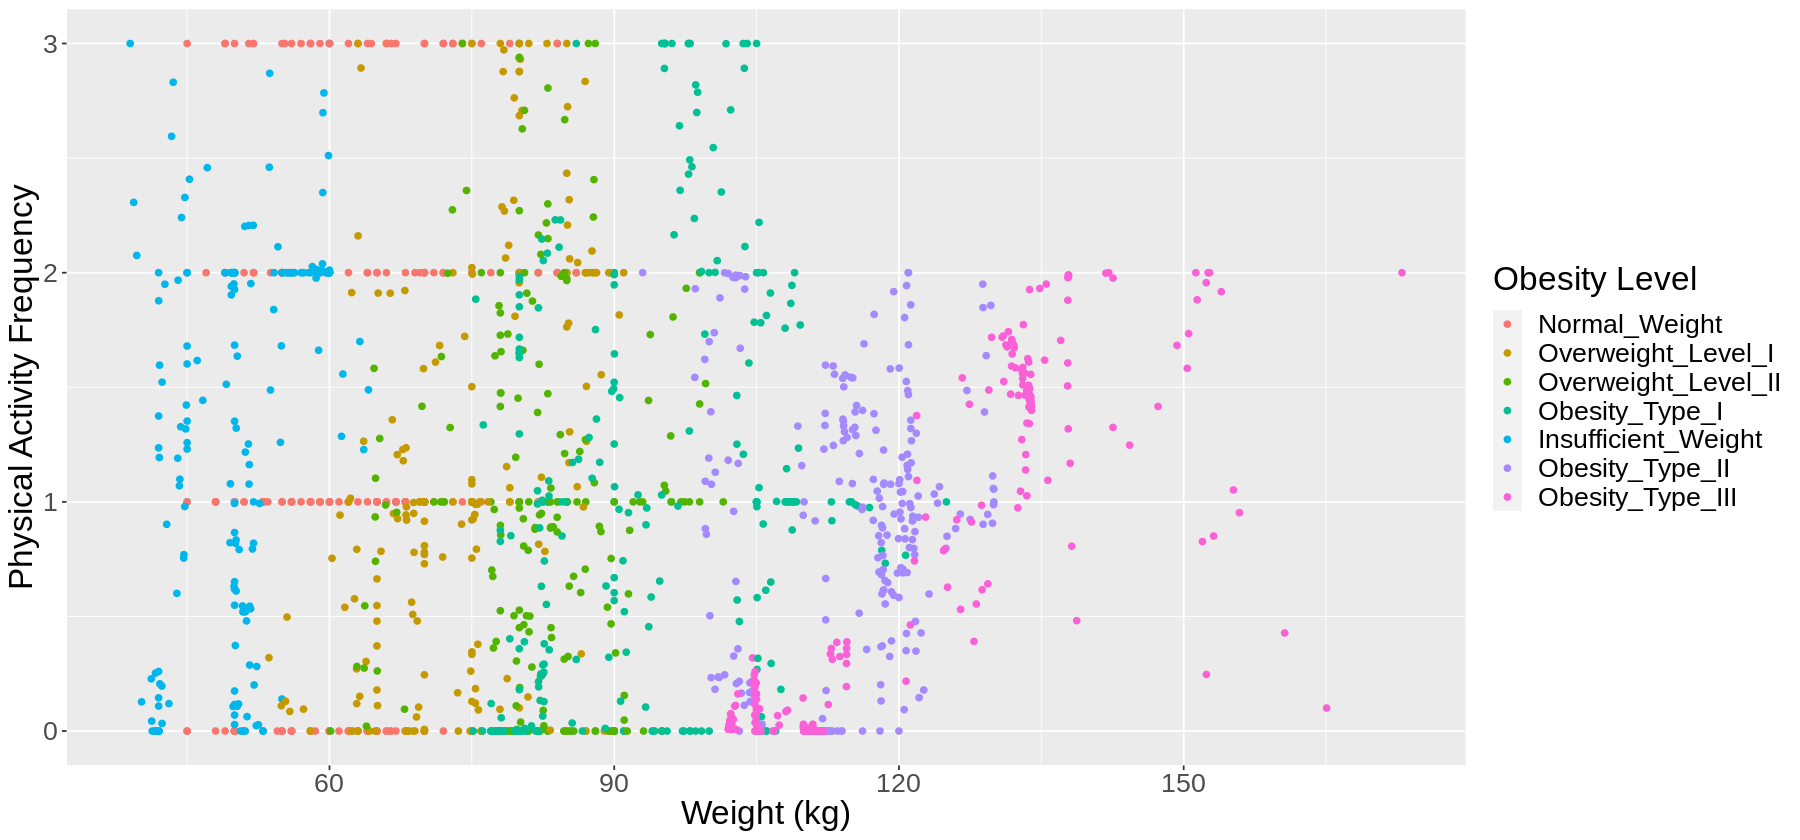

In [8]:
weight_faf_plot

From the plot above, we can see that Physical Activity Frequency has a strong contribution to the classifier only starting from the Obesity Type II.
<br>

### Finding the best K to use

To find the best K for our classifier, we are going to follow these few steps:
1. We will generate five different train/validation splits of our overall training data
2. Create the appropriate model and recipe
3. Train 

In [31]:
set.seed(255) 

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

min_vfold <- vfold_cv(obesity_train, v = 5, strata = NObeyesdad)

min_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

obesity_recipe <- recipe(NObeyesdad ~ Weight + FAF + CH2O + TUE, data = obesity_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())  



k_data <- workflow() %>%
        add_recipe(obesity_recipe) %>%
        add_model(min_spec) %>%
        tune_grid(resamples = min_vfold, grid = k_vals) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        arrange(desc(mean))

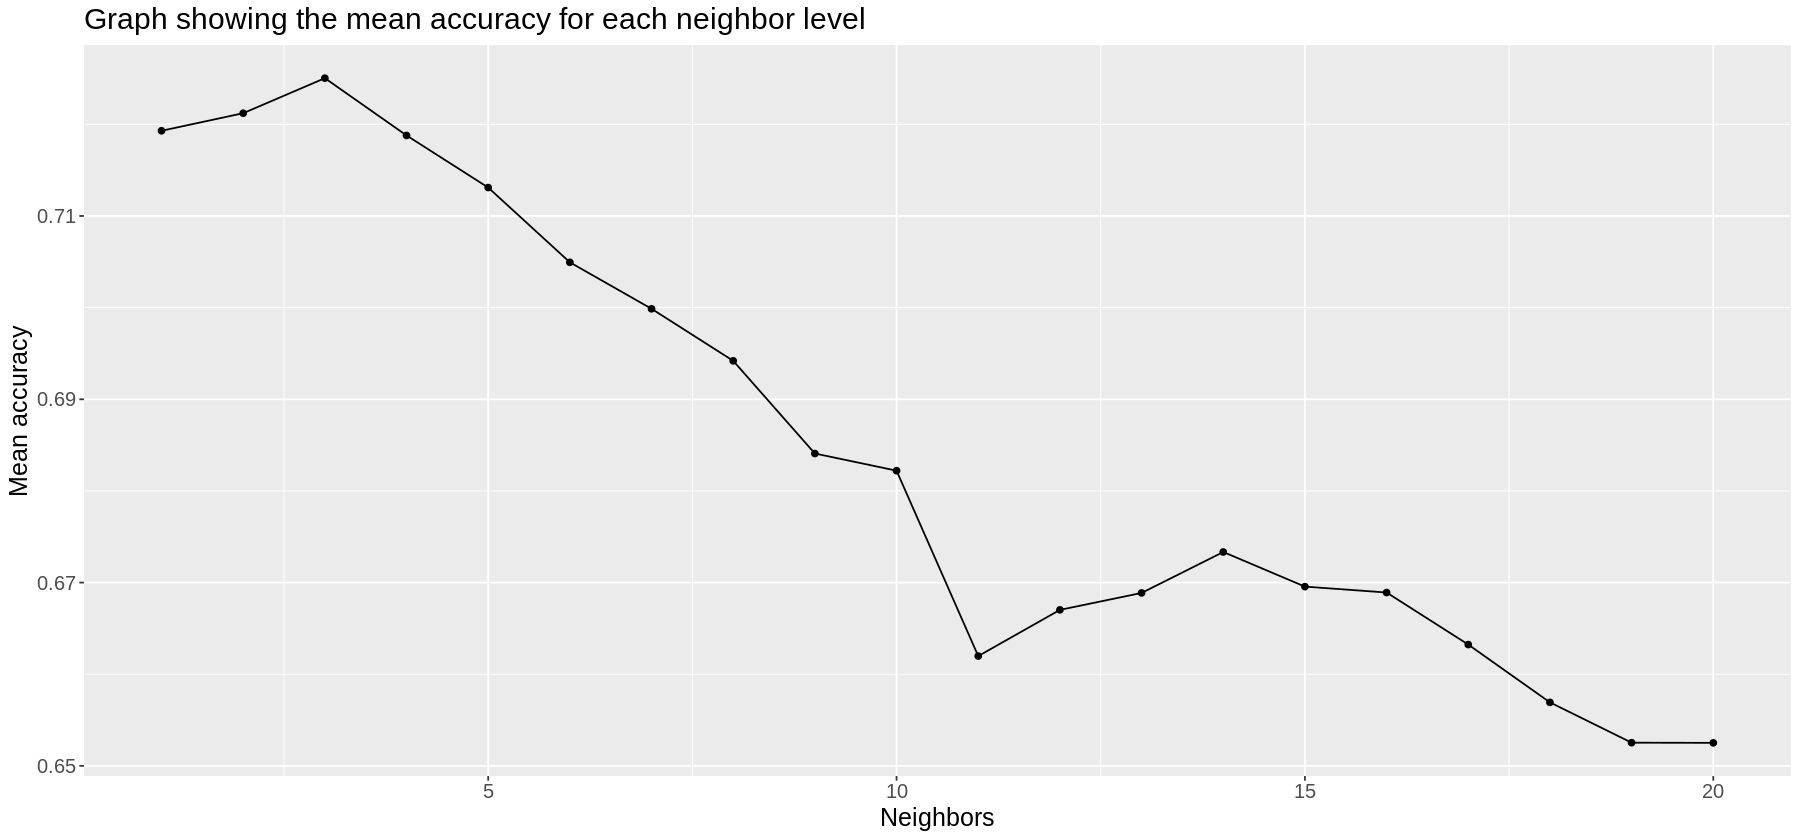

In [32]:
k_plot <- ggplot(k_data, aes(x = neighbors, y = mean)) +
            geom_line() +
            geom_point() +
            labs(x = "Neighbors", y = "Mean accuracy", title = "Graph showing the mean accuracy for each neighbor level") +
            theme(text = element_text(size = 15))

k_plot

k_min <- k_data %>%
            slice(1) %>%
            pull(neighbors)

In [33]:
k_data

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.7250381,5,0.009513635,Model03
2,accuracy,multiclass,0.7212164,5,0.008922966,Model02
1,accuracy,multiclass,0.7192995,5,0.008500580,Model01
4,accuracy,multiclass,0.7187884,5,0.007014920,Model04
5,accuracy,multiclass,0.7131022,5,0.007478072,Model05
6,accuracy,multiclass,0.7049435,5,0.006395819,Model06
7,accuracy,multiclass,0.6998718,5,0.005371135,Model07
8,accuracy,multiclass,0.6941952,5,0.006455523,Model08
9,accuracy,multiclass,0.6840798,5,0.005689086,Model09


To determine the k-value we would like to use for our KNN classification, we chose the value of 3 from the figure above as the accuracy was the highest (72.5%).

### Using our K to create the model

In [ ]:
set.seed(255)

obesity_vfold <- vfold_cv(obesity_train, v = 5, strata = NObeyesdad)

obesity_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = k_min) %>%
                set_engine("kknn") %>%
                set_mode("classification")


obesity_fit <- workflow() %>%
        add_recipe(obesity_recipe) %>%
        add_model(obesity_spec) %>%
        fit(obesity)

## Testing the model

In [ ]:
set.seed(255)
predictions <- predict(obesity_fit, obesity_test) %>%
                bind_cols(obesity_test)

head(predictions)

obesity_metrics <- predictions %>%
                metrics(truth = NObeyesdad, estimate = .pred_class)

obesity_conf_mat <- predictions %>%
                conf_mat(truth = NObeyesdad, estimate = .pred_class)


obesity_metrics

obesity_conf_mat

### Prediction

In [ ]:
set.seed(255)
new_obs <- tibble(Weight = runif(1,60,100), FAF = runif(1,0,3), CH2O = runif(1,0,2), TUE = runif(1,0,3), NObeyesdad = "Unknown")

obesity_new <- rbind(obesity, new_obs)

new_pred <- predict(obesity_fit, new_obs) %>%
                    bind_cols(new_obs) %>%
                    rename(Prediction = .pred_class) %>%
                    select(-"NObeyesdad") %>%
                    relocate(Prediction, .after = TUE)

new_pred

For the unknown new observation, the classifier predicted the obesity level class of the individual to be Overweight Level II.

## Visualization of the analysis

In [ ]:
options(repr.plot.width = 20, repr.plot.length = 20)
names <- c("Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I", "Insufficient_Weight ","Obesity_Type_II", "Obesity_Type_III")

matrix <- matrix(unlist(obesity_conf_mat), ncol = 7, nrow = 7)

matrix_df <- round((matrix/colSums(matrix))*100,2) %>%
                        as.data.frame()

colnames(matrix_df)  <- names

matrix_df_2 <-  matrix_df %>%
                mutate(Prediction = names) %>%
                relocate(Prediction, .before = Normal_Weight) %>%
                melt()


matrix_df_2$Prediction <- factor(matrix_df_2$Prediction,levels=names)
matrix_df_2$variable <- factor(matrix_df_2$variable, levels=names)

matrix_heatmap <- ggplot(matrix_df_2, aes(x = variable, y = Prediction, fill = value)) +
                    geom_tile() +
                    geom_text(aes(label = value), color = "white", size = 6) +
                    labs(x = "Truth", y = "Prediction", fill = "Prediction accuracy per class", title = "Heatmap of the confusion matrix") +
                    theme(text = element_text(size = 18))
                    
matrix_heatmap

The figure above depicts a visualization of the confusion matrix for the classifier in a heatmap form. This confusion matrix is a table showing the prediction accuracy per class of our classifer via predicted and correct labels. For example, the new observation that we classified for this project was classified in the Overweight Level II obesity class. The confusion matrix shows that the classifer has a 75% prediction accuracy for this class. The visualization is one of the important tools we used to critically analyze the performance of our classifier.